# Penn Interactive Data Science Challenge - Tim Wall

This notebook contains the contents of the coding challenge, both what was provided in the original *bitcoin-predictor.ipynb* notebook and additional model code built by Tim for this challenge.

## Initial Data Load/analysis

In [1]:
# Loading associated DS packages
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np

# Set option to view more rows of data
pd.set_option('max_rows',1000)
pd.set_option('max_columns',50)

# Keras model packages from demo model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

# other packages for plotting tables/values
import matplotlib.pyplot as plt

#### Loading the data, parsing datetime columns.

In [2]:
data = pd.read_csv('bitcoin.csv',parse_dates=['time_period_start','time_period_end','time_open','time_close'])
data.sort_values('time_period_start',inplace=True)
data.reset_index(drop=True,inplace=True)
data.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2020-01-01 00:00:00+00:00,2020-01-01 00:00:01+00:00,2020-01-01 00:00:00.222256+00:00,2020-01-01 00:00:00.822153+00:00,7165.72,7165.72,7165.71,7165.71,0.021841,2
1,2020-01-01 00:00:01+00:00,2020-01-01 00:00:02+00:00,2020-01-01 00:00:01.949000+00:00,2020-01-01 00:00:01.953000+00:00,7168.30,7168.30,7168.30,7168.30,1.000000,2
2,2020-01-01 00:00:02+00:00,2020-01-01 00:00:03+00:00,2020-01-01 00:00:02.555000+00:00,2020-01-01 00:00:02.555000+00:00,7170.50,7170.50,7170.50,7170.50,0.002000,1
3,2020-01-01 00:00:04+00:00,2020-01-01 00:00:05+00:00,2020-01-01 00:00:04.171000+00:00,2020-01-01 00:00:04.560000+00:00,7169.20,7169.20,7169.20,7169.20,0.004000,2
4,2020-01-01 00:00:05+00:00,2020-01-01 00:00:06+00:00,2020-01-01 00:00:05.379000+00:00,2020-01-01 00:00:05.379000+00:00,7169.20,7169.20,7169.20,7169.20,0.002000,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   time_period_start  10000 non-null  datetime64[ns, UTC]
 1   time_period_end    10000 non-null  datetime64[ns, UTC]
 2   time_open          10000 non-null  datetime64[ns, UTC]
 3   time_close         10000 non-null  datetime64[ns, UTC]
 4   price_open         10000 non-null  float64            
 5   price_high         10000 non-null  float64            
 6   price_low          10000 non-null  float64            
 7   price_close        10000 non-null  float64            
 8   volume_traded      10000 non-null  float64            
 9   trades_count       10000 non-null  int64              
dtypes: datetime64[ns, UTC](4), float64(5), int64(1)
memory usage: 781.4 KB


In [4]:
data.describe()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7190.667163,7190.891258,7190.445922,7190.663989,0.316941,1.748300
std,18.318254,18.311377,18.356907,18.341736,1.810771,2.215815
min,7144.620000,7144.620000,7136.050000,7144.620000,0.000008,1.000000
25%,7184.950000,7185.000000,7184.757500,7184.887500,0.006210,1.000000
50%,7196.970000,7197.310000,7196.640000,7196.960000,0.015223,1.000000
75%,7203.250000,7203.400000,7203.010000,7203.250000,0.068103,2.000000
max,7223.500000,7224.530000,7223.400000,7223.500000,65.014193,88.000000


#### Plot different price values over time, just to understand overall trend.


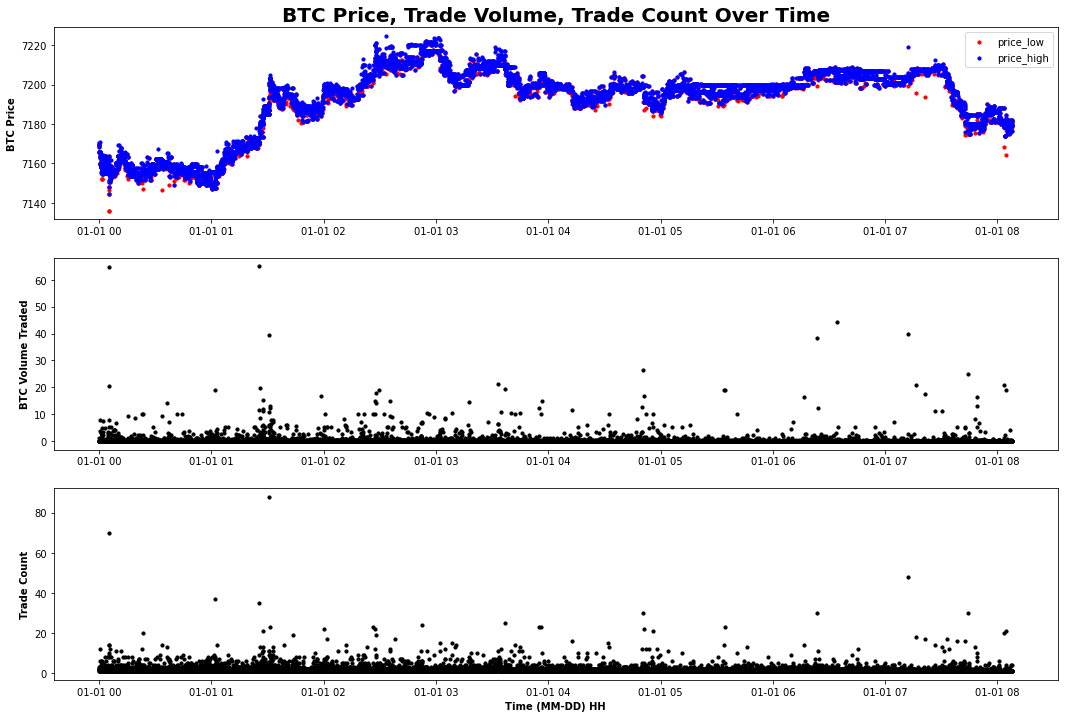

In [5]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,figsize=(18,12))
# plot prices over time
ax1.scatter(data.time_period_start,data.price_low,label='price_low',c='r',s=10)
ax1.scatter(data.time_period_start,data.price_high,label='price_high',c='b',s=10)
ax1.set_ylabel('BTC Price',fontweight='bold')
# ax1.set_xlabel('Time (MM-DD) HH',fontweight='bold')
ax1.legend()

# plot volume over time
ax2.scatter(data.time_period_start,data.volume_traded,label='volume_traded',c='k',s=10)
ax2.set_ylabel('BTC Volume Traded',fontweight='bold')
# ax2.set_xlabel('Time (MM-DD) HH',fontweight='bold')

# plot # trades over time
ax3.scatter(data.time_period_start,data.trades_count,label='trade_count',c='k',s=10)
ax3.set_ylabel('Trade Count',fontweight='bold')
ax3.set_xlabel('Time (MM-DD) HH',fontweight='bold')

ax1.set_title('BTC Price, Trade Volume, Trade Count Over Time',fontweight='bold',fontsize=20)

plt.show()

#### Plot sorted raw values, just to understand value distribution.


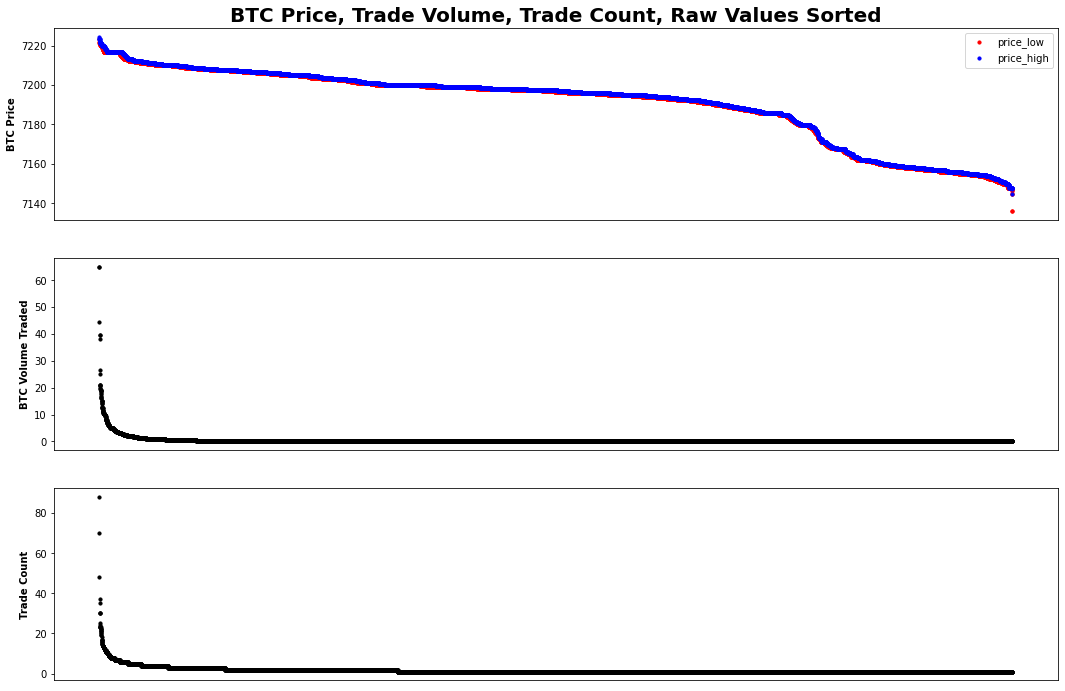

In [6]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,figsize=(18,12))

# plot raw price values
ax1.scatter(data.index,data.price_low.sort_values(ascending=False),label='price_low',c='r',s=10)
ax1.scatter(data.index,data.price_high.sort_values(ascending=False),label='price_high',c='b',s=10)
ax1.set_ylabel('BTC Price',fontweight='bold')
ax1.set_xticks([])
ax1.legend()

# plot raw volume values
ax2.scatter(data.index,data.volume_traded.sort_values(ascending=False),label='volume_traded',c='k',s=10)
ax2.set_ylabel('BTC Volume Traded',fontweight='bold')
ax2.set_xticks([])

# plot raw trades values
ax3.scatter(data.index,data.trades_count.sort_values(ascending=False),label='trade_count',c='k',s=10)
ax3.set_ylabel('Trade Count',fontweight='bold')
ax3.set_xticks([])
# ax3.set_xlabel('Value Rank',fontweight='bold')

ax1.set_title('BTC Price, Trade Volume, Trade Count, Raw Values Sorted',fontweight='bold',fontsize=20)

plt.show()

We can infer at a high level from this data that: 
- price_high and price_low are very closely linked (which we might expect when each window is 1 second long) 
- Volume Traded and Trade Count are often very small, with very intermittent peaks of larger values. This can be seen in the .describe() block, when the 75th percentile values for volume_traded and trades_count are 0.68 and 2 respectively, yet the max values for both are much larger; indeed, as seen by sorting the raw values below, only a small subset of values have more than a small number of transactions.
- This data does not actually show BTC values at every second. If you look at the following cell, it will show an example of what that looks like.

In [7]:
# compare end time of previous line to start time of current line
data['prev_time_period_end'] = data.time_period_end.shift(1)
data['delta_seconds'] = data.time_period_start - data['prev_time_period_end']
data['delta_seconds'] = data['delta_seconds'].apply(lambda x: x.seconds)

# if the data actually captures every second, delta_seconds should never be > 0 (meaning time_period_end
# of a line should always match time_period_start of the following line)

data.loc[
    (data.delta_seconds > 0)
]

# I will correct for this later.

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count,prev_time_period_end,delta_seconds
3,2020-01-01 00:00:04+00:00,2020-01-01 00:00:05+00:00,2020-01-01 00:00:04.171000+00:00,2020-01-01 00:00:04.560000+00:00,7169.20,7169.20,7169.20,7169.20,0.004000,2,2020-01-01 00:00:03+00:00,1.0
6,2020-01-01 00:00:08+00:00,2020-01-01 00:00:09+00:00,2020-01-01 00:00:08.690668+00:00,2020-01-01 00:00:08.882466+00:00,7165.72,7165.72,7165.72,7165.72,0.017024,2,2020-01-01 00:00:07+00:00,1.0
11,2020-01-01 00:00:14+00:00,2020-01-01 00:00:15+00:00,2020-01-01 00:00:14.778000+00:00,2020-01-01 00:00:14.778000+00:00,7163.80,7163.80,7163.80,7163.80,0.300000,1,2020-01-01 00:00:13+00:00,1.0
13,2020-01-01 00:00:24+00:00,2020-01-01 00:00:25+00:00,2020-01-01 00:00:24.034538+00:00,2020-01-01 00:00:24.753688+00:00,7165.72,7170.79,7165.72,7165.72,0.036206,3,2020-01-01 00:00:16+00:00,8.0
14,2020-01-01 00:00:26+00:00,2020-01-01 00:00:27+00:00,2020-01-01 00:00:26.549000+00:00,2020-01-01 00:00:26.549000+00:00,7165.10,7165.10,7165.10,7165.10,0.000010,1,2020-01-01 00:00:25+00:00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2020-01-01 08:07:40+00:00,2020-01-01 08:07:41+00:00,2020-01-01 08:07:40.827399+00:00,2020-01-01 08:07:40.827399+00:00,7179.04,7179.04,7178.23,7178.23,0.055989,4,2020-01-01 08:07:39+00:00,1.0
9995,2020-01-01 08:07:45+00:00,2020-01-01 08:07:46+00:00,2020-01-01 08:07:45.142437+00:00,2020-01-01 08:07:45.142437+00:00,7179.50,7179.50,7179.50,7179.50,0.013325,1,2020-01-01 08:07:41+00:00,4.0
9996,2020-01-01 08:07:53+00:00,2020-01-01 08:07:54+00:00,2020-01-01 08:07:53.888000+00:00,2020-01-01 08:07:53.888000+00:00,7181.67,7181.67,7181.67,7181.67,0.013364,1,2020-01-01 08:07:46+00:00,7.0
9997,2020-01-01 08:07:57+00:00,2020-01-01 08:07:58+00:00,2020-01-01 08:07:57.544917+00:00,2020-01-01 08:07:57.544917+00:00,7179.50,7179.50,7179.50,7179.50,0.001526,1,2020-01-01 08:07:54+00:00,3.0


In [8]:
data.drop(['prev_time_period_end','delta_seconds'],axis=1,inplace=True)

## Lookback Window (from bitcoin-predictor)

*(I've kept these next few cells essentially the same. My comments on this model will come after.)*

In order to capture the past as features, we create the below function. It takes as input some number of seconds to look back, defaulted to 60 seconds.

In [9]:
def lookback(dataset, timesteps = 60):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    data = dataset
    for i in range(1, timesteps):
        step_back = dataset.shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset.columns if column != 'index']
        data = data.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
        
    return data.dropna()



features = lookback(data.drop(['time_period_start','time_period_end','time_open','time_close'],axis=1))

In [10]:
features.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,price_open_-1,price_high_-1,price_low_-1,price_close_-1,volume_traded_-1,trades_count_-1,price_open_-2,price_high_-2,price_low_-2,price_close_-2,volume_traded_-2,trades_count_-2,price_open_-3,price_high_-3,price_low_-3,price_close_-3,volume_traded_-3,trades_count_-3,price_open_-4,...,trades_count_-55,price_open_-56,price_high_-56,price_low_-56,price_close_-56,volume_traded_-56,trades_count_-56,price_open_-57,price_high_-57,price_low_-57,price_close_-57,volume_traded_-57,trades_count_-57,price_open_-58,price_high_-58,price_low_-58,price_close_-58,volume_traded_-58,trades_count_-58,price_open_-59,price_high_-59,price_low_-59,price_close_-59,volume_traded_-59,trades_count_-59
59,7154.97,7154.97,7154.97,7154.97,2.000000,2,7163.30,7163.30,7163.30,7163.30,0.000010,1.0,7164.23,7164.23,7151.92,7151.92,0.902636,4.0,7154.82,7154.82,7151.92,7151.92,0.084111,2.0,7161.20,...,1.0,7169.20,7169.20,7169.20,7169.20,0.004000,2.0,7170.50,7170.50,7170.50,7170.50,0.002000,1.0,7168.30,7168.3,7168.30,7168.3,1.000000,2.0,7165.72,7165.72,7165.71,7165.71,0.021841,2.0
60,7161.20,7163.40,7161.20,7163.40,0.015800,2,7154.97,7154.97,7154.97,7154.97,2.000000,2.0,7163.30,7163.30,7163.30,7163.30,0.000010,1.0,7164.23,7164.23,7151.92,7151.92,0.902636,4.0,7154.82,...,3.0,7169.20,7169.20,7169.20,7169.20,0.002000,1.0,7169.20,7169.20,7169.20,7169.20,0.004000,2.0,7170.50,7170.5,7170.50,7170.5,0.002000,1.0,7168.30,7168.30,7168.30,7168.30,1.000000,2.0
61,7154.98,7154.98,7154.97,7154.98,0.038357,3,7161.20,7163.40,7161.20,7163.40,0.015800,2.0,7154.97,7154.97,7154.97,7154.97,2.000000,2.0,7163.30,7163.30,7163.30,7163.30,0.000010,1.0,7164.23,...,2.0,7165.72,7169.20,7165.72,7169.20,0.075433,3.0,7169.20,7169.20,7169.20,7169.20,0.002000,1.0,7169.20,7169.2,7169.20,7169.2,0.004000,2.0,7170.50,7170.50,7170.50,7170.50,0.002000,1.0
62,7154.98,7154.98,7154.98,7154.98,0.032201,1,7154.98,7154.98,7154.97,7154.98,0.038357,3.0,7161.20,7163.40,7161.20,7163.40,0.015800,2.0,7154.97,7154.97,7154.97,7154.97,2.000000,2.0,7163.30,...,1.0,7165.72,7165.72,7165.72,7165.72,0.017024,2.0,7165.72,7169.20,7165.72,7169.20,0.075433,3.0,7169.20,7169.2,7169.20,7169.2,0.002000,1.0,7169.20,7169.20,7169.20,7169.20,0.004000,2.0
63,7154.97,7154.97,7154.97,7154.97,2.000000,1,7154.98,7154.98,7154.98,7154.98,0.032201,1.0,7154.98,7154.98,7154.97,7154.98,0.038357,3.0,7161.20,7163.40,7161.20,7163.40,0.015800,2.0,7154.97,...,1.0,7165.72,7165.72,7165.72,7165.72,0.040059,1.0,7165.72,7165.72,7165.72,7165.72,0.017024,2.0,7165.72,7169.2,7165.72,7169.2,0.075433,3.0,7169.20,7169.20,7169.20,7169.20,0.002000,1.0


In [11]:
### split data into features and target

target = features['price_high'].values
features = features.drop('price_high', axis=1).values

In [12]:
features.shape

(9941, 359)

In [13]:
model = Sequential()
model.add(Dense(32, input_dim=features.shape[1]))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1, activation='relu'))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01), # is this the best optimizer/learning rate?
    metrics=['mean_squared_error', 'mean_absolute_error'] # does accuracy make sense in this context?
)

## callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    features,
    target,
    validation_split=.3,
    epochs=20,
    verbose=0
)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                11520     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 12,193
Trainable params: 12,193
Non-trainable params: 0
_________________________________________________________________


In [15]:
## prediction
predictions = model.predict(features)

311/311 [==============================] - 1s 2ms/step


In [16]:
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))

In [17]:
rmse

7191.088757578544

Predictions vs. actuals, plotted

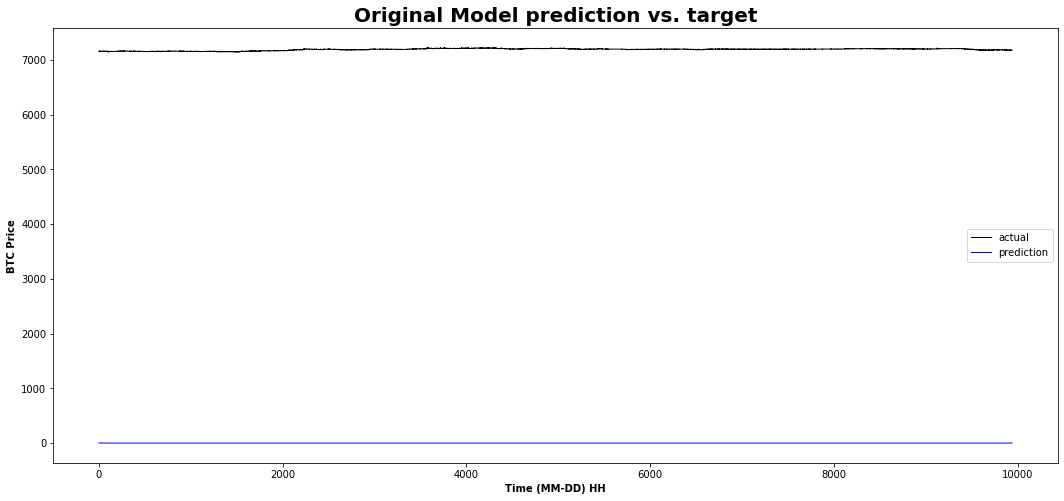

In [18]:
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(target,lw=1,c='k',label='actual')
ax.plot(predictions,lw=1,c='b',label='prediction')
ax.set_xlabel('Time (MM-DD) HH',fontweight='bold')
ax.set_ylabel('BTC Price',fontweight='bold')
ax.set_title('Original Model prediction vs. target',fontweight='bold',fontsize=20)
plt.legend()
plt.show()

There are a couple issues with this approach (one of which, of course, is that the model returns 0 at every point.)

- The data is full of features that are correlated extremely highly with the target variable. As mentioned before, the BTC price is highly correlated with all of the different price features, even when offsetting by time. So this specific featurization isn't necessarily helping us get any additional information. (see next cell for an example of some highly correlated variables)
- Values that aren't correlated as strongly that could potentially be informative (namely the trade volume and trade count) probably need to be normalized for them to have any additional value.
- There is no sort of regularization applied to any of the model inputs, which would be belpful in helping the neural network model converge.


In [19]:
features = lookback(data.drop(['time_period_start','time_period_end','time_open','time_close'],axis=1))
price_high_correlations = features.corr()[['price_high']]
price_high_correlations.sort_values('price_high',ascending=False).head(25)

,price_high
price_high,1.000000
price_open,0.998592
price_close,0.998489
price_low,0.997001
price_open_-1,0.991114
price_open_-2,0.990845
price_low_-1,0.990820
price_close_-1,0.990692
price_low_-2,0.990660
price_high_-1,0.990616


## Finding a better-performing model

The data preparation and current neural network model, as implemented, is not capturing what we are hoping for.

So to go forward, I would like to make some adjustments to the data, as well as what we are looking for.

#### First step: create new DataFrame where every second is accounted for between 0:00 and 8:00 on 1/1/2020.

In [20]:
# set time_period_start as basis for merge
data.set_index('time_period_start',inplace=True)
data.index.tz_convert(None)
data.head()

# generate new table that has row for every second and merge old data to it
new_index = pd.date_range('1/1/2020', periods=8*3600+1, freq='S',tz='UTC')
new_data = pd.DataFrame(index=new_index)
new_data = new_data.merge(data,left_index=True,right_index=True,how='outer')

# to impute values, I decided to simply ffill the previous recorded value 
# (could have also done a linear interpolate.)
# Also could have used the price_close to inform the gaps in the model.
# For trade volume + count, assumed they were 0 during the empty period.
for c in ['price_open','price_high','price_low','price_close']:
    new_data[c] = new_data[c].ffill()
#     new_data[c] = new_data[c].interpolate(method='linear')
new_data['volume_traded'] = new_data['volume_traded'].fillna(0)
new_data['trades_count'] = new_data['trades_count'].fillna(0)

new_data.drop(['time_period_end','time_open','time_close'],axis=1,inplace=True)

new_data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
2020-01-01 00:00:00+00:00,7165.72,7165.72,7165.71,7165.71,0.021841,2.0
2020-01-01 00:00:01+00:00,7168.30,7168.30,7168.30,7168.30,1.000000,2.0
2020-01-01 00:00:02+00:00,7170.50,7170.50,7170.50,7170.50,0.002000,1.0
2020-01-01 00:00:03+00:00,7170.50,7170.50,7170.50,7170.50,0.000000,0.0
2020-01-01 00:00:04+00:00,7169.20,7169.20,7169.20,7169.20,0.004000,2.0


In [21]:
new_data.corr()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
price_open,1.000000,0.998682,0.998550,0.997580,-0.011244,-0.045450
price_high,0.998682,1.000000,0.997185,0.998498,-0.002911,-0.034204
price_low,0.998550,0.997185,1.000000,0.998708,-0.024057,-0.058078
price_close,0.997580,0.998498,0.998708,1.000000,-0.015025,-0.047033
volume_traded,-0.011244,-0.002911,-0.024057,-0.015025,1.000000,0.696943
trades_count,-0.045450,-0.034204,-0.058078,-0.047033,0.696943,1.000000


#### Next step: creating additional features

There are 2 different features I want to add:
- price_delta_60 - the delta between the price 60 seconds ago vs. now. e.g. if the price 60 seconds ago was 200 and the current price is 190, the price_delta_60 value is -10.
- rolling sums of trade volume and count - the rolling sum of trade volume and trade count over the previous 60 seconds.

Whether or not we use these is another question, but it can potentially be of use with respect to different model targets.

In [22]:
new_data['price_delta_60'] = new_data['price_high'].shift(60)
new_data['price_delta_60'] = new_data['price_high'] - new_data['price_delta_60']

new_data['volume_traded_rolling60'] = new_data.volume_traded.rolling(60).sum()
new_data['trades_count_rolling60'] = new_data.trades_count.rolling(60).sum()

#### Next step: building the simplest of models (moving average, EWMA)

To see if a simpler model might provide some decent results, I wanted to build 2 very simple models:
- 60 seconds weighted average - simply takes the mean of the last 60 seconds of price_high values.
- 60 seconds EWMA - Exponentially weighted moving average of last 60 seconds of price_high values.


In [23]:
# MA
new_data['price_high_ma60'] = new_data.price_high.rolling(60).mean()
# EWMA
new_data['price_high_ewma60'] = new_data.price_high.ewm(span=60,min_periods=60).mean()

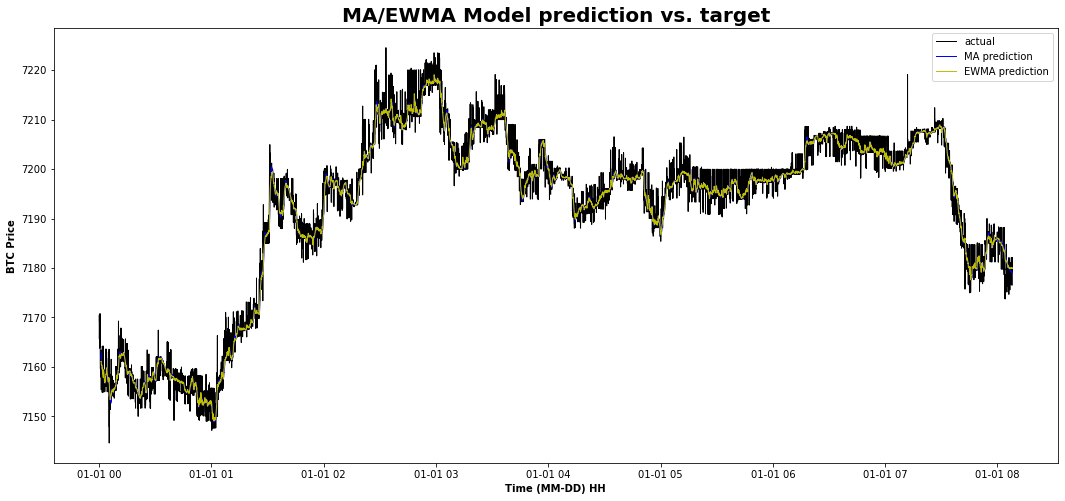

In [24]:
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(new_data.price_high,lw=1,c='k',label='actual')
ax.plot(new_data.price_high_ma60,lw=1,c='b',label='MA prediction')
ax.plot(new_data.price_high_ewma60,lw=1,c='y',label='EWMA prediction')
ax.set_xlabel('Time (MM-DD) HH',fontweight='bold')
ax.set_ylabel('BTC Price',fontweight='bold')
ax.set_title('MA/EWMA Model prediction vs. target',fontweight='bold',fontsize=20)
plt.legend()
plt.show()

Using root mean squared error (MSE) as measure of accuracy. This just gives us a basic idea of how close the output of this moving average is to the actual new BTC price.


In [25]:
pred_data = new_data.iloc[60:]
mse_ma = mean_squared_error(pred_data.price_high,pred_data.price_high_ma60)
mse_ewma = mean_squared_error(pred_data.price_high,pred_data.price_high_ewma60)

print(f'RMSE of moving average estimate: {mse_ma ** 0.5}')
print(f'RMSE of EWMA estimate: {mse_ewma ** 0.5}')

RMSE of moving average estimate: 1.9647492980073296
RMSE of EWMA estimate: 1.8317984389593953


#### Next step: Improving prediction with neural network

We were able to slightly improve over a simple moving average by a basic application of exponential weighting. While this is simple, over time we might not expect this kind of basic model to improve accuracy given more data (indeed, we are not using more than 60 seconds of data no matter how long the dataset stretches for).

With a neural network, we might be able to generate a model that is more likely to improve accuracy over time given more data.

The first pass at neural network creation is to generate a neural network based on the previous 60 seconds of price_high values only, with min-max normalization.

I also made an adjustment to incorporate relu activation function in each layer of the model. The issue with the previous version of the model is likely tied to not having an activation function there

In [26]:
ts = 60

# implemented my own version of min max normalization.

target_col = 'pricehigh_minmax'
price_high_max = new_data.price_high.max()
price_high_min = new_data.price_high.min()

new_data[target_col] = (new_data.price_high - price_high_min).divide(price_high_max - price_high_min)

features = lookback(new_data.reset_index(drop=True),timesteps=ts)
features = features.filter(regex=f'{target_col}*')

target_adj = features[target_col].values
features = features.drop(target_col, axis=1).values


In [27]:
model = Sequential()
model.add(LSTM(8, return_sequences=False, input_shape=(features.shape[1],1)))
model.add(Dense(1, activation='relu'))

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.01), # is this the best optimizer/learning rate?
    metrics=['mean_squared_error'] # does accuracy make sense in this context?
)

## callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    features,
    target_adj,
    validation_split=.3,
    epochs=20,
    verbose=0
)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [29]:
predictions = model.predict(features)

900/900 [==============================] - 8s 8ms/step


Convert model prediction and target to BTC price

In [30]:
predictions = (predictions * (price_high_max - price_high_min)) + price_high_min
target = (target_adj * (price_high_max - price_high_min)) + price_high_min

Plot model output vs. actual value

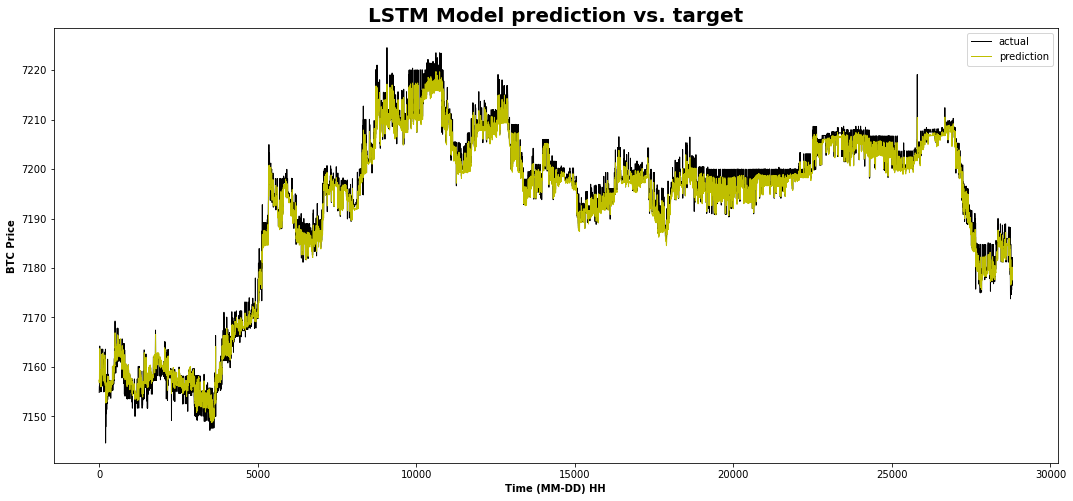

In [31]:
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(target,lw=1,c='k',label='actual')
ax.plot(predictions,lw=1,c='y',label='prediction')
ax.set_xlabel('Time (MM-DD) HH',fontweight='bold')
ax.set_ylabel('BTC Price',fontweight='bold')
ax.set_title('LSTM Model prediction vs. target',fontweight='bold',fontsize=20)
plt.legend()
plt.show()

In [32]:
mse_model = mean_squared_error(pred_data.price_high[59:],predictions)

print(f'RMSE of moving average estimate: {mse_ma ** 0.5}')
print(f'RMSE of EWMA estimate: {mse_ewma ** 0.5}')
print(f'RMSE of simple LSTM Model estimate: {mse_model ** 0.5}')

RMSE of moving average estimate: 1.9647492980073296
RMSE of EWMA estimate: 1.8317984389593953
RMSE of simple LSTM Model estimate: 1.6119259478098686


#### In this case, a simple neural network based only on 60 seconds of price_high values with just 1 LSTM layer and a Dense layer with relu activation was able to improve the model performance from EWMA (i.e. lower the RMSE).

It might be possible to improve this model even further, by adding more data, more layers in the model, more different types of layers, adding additional parameters in the training set, and adjusting the window from 60 seconds to more.

## Understanding future questions to ask

Obviously it's impossible to cover all the possible directions that could be taken in the search for an algorithm that can more accurately predict the price of Bitcoin. But I believe there are more questions that could be asked in the course of such a project.

- What are we trying to solve with this algorithm?
    - We have been assuming for the sake of this problem that we just want to more accurately predict the price of Bitcoin. But what might we try to do with that information? Are we simply looking for optimal times to buy/sell? Do we want to anticipate major spikes/dips in price? It might change what we do with the information we learn from the model, or adjust the model itself.
- Do we care about the explainability of the model to stakeholders?
    - If so, then a neural network may not be the best approach - it is a bit more complex to communicate than a simple average or a simpler model like a regression or a tree. We might be able to achieve similar results with a those types of models.
- Are we trying to hit a certain error threshold?
    - If our model is not yet good enough, we would need to do more hyperparameter tuning, or perhaps change the structure of our neural network, or evaluate additional data we could add.
- Will our approach change with more data?
    - This could either be accumulating more data over time (in which case we could increase the window we are looking at to be more than at the seconds level, or looking at more than 60 seconds) or simply adding more fields to compare against (for instance, how other cryptocurrencies are performing.)

## Answering the questions from the README

#### Does this data set even make sense? What are the limitations of this data set?
It certainly makes sense that a dataset for predicting BTC prices would include such information as high/low price, trade volume and count, etc. It is similar to stock pricing data in that way. But looking at resolutions of only one second, there is a limited amount of information we might be able to gain in that time frame.

#### Is the lookback window of 60 seconds helpful? What are its limitations? What other features would you want to see in this data set?
A 60 second window might be useful in helping to target point fluctuations of BTC price, as well as a general direction of BTC price trend. But on a macro scale, it is probably too small a window to get long-term projections of BTC price. 

#### If you stuck with the neural network, what did you change to make it better? Did you change the architecture, did you change the optimizer? The learning rate? The activation function(s)? Why was the model stuck at 0 with an incredibly high root mean squared error?
The main thing I tinkered with is adding different activation functions to the current version of the model; I also played with adding an LSTM layer to the model as well as optimizing on MSE only. I played around with different learning rates, and probably could have seen what multiple LSTM layers (with dropout) could have done to improve upon the first pass. 
The model was likely stuck at 0 due to not having an activation function for the Dense layer until the final layer.

#### If you used a different model, why'd you choose this model? What about it made it work for this problem? Is this model complex and if so, is the complexity necessary? Is it intuitive enough to explain it to a lay-person? What was your optimizing metric? What were the hyperparameters and why'd you choose them?
I used a moving average + exponentially weighted moving average to compare against. Those models are helpful in that they are both easy to explain, fit well with a time-series approach, and provide a baseline for what a potential neural network could improve over. I didn't need to optimize anything per se (besides set the observation window to 60 seconds).

#### Did you include any regularization strategies in your model? If so, why'd you choose the one you did?
For the neural network I used min-max regularization (trained on the target set and applied to both sets). Given that there aren't many price outliers in the BTC price data, this would seem most effective at standardizing units.
If I had included the transaction volume and count in the model, I would likely have standardized that with some sort of logistic regression (or other sort of threshold flag) given the rather skewed, unbalanced distribution of such data.

#### Did you include visualizations? (everyone loves a good graphic)
I did include a few comparisons of model output to actual values, as well as observations of the values themselves.

#### How do we know the model is good? How understandable are the diagnostics? How will we know how good the model is predicting in production?
"Good" is partly dependent on the target we are after, but given that a basic neural network has lower RMSE than something like a moving average, it seems that we are at least on a right track. (RMSE is fairly interpretable as an error metric as lower = good and it is comparable across all predictions.) In production, we can provide some sort of running report of model performance in this way over time.

#### If we see data for more than a single day's worth of prices, how do expect the model to perform? Will it generalize well to new data? Will retraining with this new data be an issue for this model?
We would expect that the neural network would continue to improve with new data, at least to a certain point, and it should generalize well enough to new data. We might need to be wary of potential impacts of massive BTC price swings (for instance, these prices are in the 7K range, but BTC has reached an order of magnitude greater since this sample was taken) as well as other outliers. We might also want to explore other model imporvements and adjustments. But for now, this model is simple enough to be effective as a predictor. 

#### What question would you ask of the data, or add to this analysis that I haven't thought of?
See the "Understanding future questions to ask" section above